## Location-Aware Real Estate Price & Recommendation Engine

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("./Dataset/gurgaon_10k.csv")

print("Initial shape:", df.shape)

selected_cols = [
    'PREFERENCE', 'DESCRIPTION', 'PROPERTY_TYPE', 'CITY', 'LOCALITY', 'TRANSACT_TYPE', 'OWNTYPE',
    'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'PRICE_PER_UNIT_AREA', 'FURNISH', 'FACING', 'AGE',
    'FLOOR_NUM', 'TOTAL_FLOOR', 'FEATURES', 'SUPERBUILTUP_SQFT', 'AMENITIES', 'TOTAL_LANDMARK_COUNT',
    'CONTACT_NAME', 'SOCIETY_NAME', 'CITY_ID', 'location', 'QUALITY_SCORE', 'MIN_PRICE','AREA'
]

df = df[selected_cols]

# Convert to categorical
df['FURNISH'] = df['FURNISH'].astype('category')
df['FACING'] = df['FACING'].astype('category')
df['PROPERTY_TYPE'] = df['PROPERTY_TYPE'].astype('category')
df['LOCALITY'] = df['LOCALITY'].astype('category')
df['TRANSACT_TYPE'] = df['TRANSACT_TYPE'].fillna(0).astype(int)
df['AREA'] = df['AREA'].str.replace('sq.ft.', '', regex=False).str.strip()
df['AREA'] = pd.to_numeric(df['AREA'], errors='coerce')

# Encode categories
df['PROPERTY_TYPE_CODE'] = df['PROPERTY_TYPE'].cat.codes
df['LOCALITY_CODE'] = df['LOCALITY'].cat.codes

# Target variable
df['TARGET_PRICE'] = df['MIN_PRICE']
print("Final shape (no filters):", df.shape)



Initial shape: (10704, 67)
Final shape (no filters): (10704, 30)


C:\Users\Sarvesh Ram Kumar\AppData\Local\Temp\ipykernel_18028\3893602707.py:4: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Dataset/gurgaon_10k.csv")


In [2]:
# Replace 'G' with 0
df['FLOOR_NUM'] = df['FLOOR_NUM'].replace('G', 0)

# Convert to numeric and fill NaNs with -1 (explicitly "not applicable")
df['FLOOR_NUM'] = pd.to_numeric(df['FLOOR_NUM'], errors='coerce').fillna(-1).astype(int)
FEATURE_SCORE_MAP = {
    1: 5,   # Swimming Pool
    2: 4,   # Power Backup
    3: 4,   # Club house
    4: 3,   # Parking
    6: 2,   # Park
    9: 4,   # Security Personnel
    11: 1,  # ATM
    12: 4,  # Gymnasium
    21: 3,  # Lift
    25: 2,  # Waste disposal
    29: 3,  # Gas Pipeline
    34: 3,  # Wheelchair Accessibility
    35: 2,  # DG Availability
    39: 1   # Near bank
}
def score_features(feature_str):
    if pd.isna(feature_str):
        return 0
    ids = [int(i.strip()) for i in feature_str.split(',') if i.strip().isdigit()]
    return sum(FEATURE_SCORE_MAP.get(i, 0) for i in ids)

df['FEATURE_SCORE'] = df['FEATURES'].apply(score_features)

AMENITY_SCORE_MAP = {
    1: 18,   # Swimming Pool
    2: 10,   # Power Back-up
    3: 5,   # Club house / Community Center
    5: 4,   # Feng Shui / Vaastu Compliant
    6: 15,   # Park
    8: 15,   # Private Garden / Terrace
    9: 13,   # Security Personnel
    10: 17,  # Centrally Air Conditioned
    11: 5,  # ATM
    12: 10,  # Fitness Centre / GYM
    13: 15,  # Cafeteria / Food Court
    15: 15,  # Bar / Lounge
    16: 10,  # Conference room
    17: 17,  # Security / Fire Alarm
    19: 5,  # Visitor Parking
    20: 5,  # Intercom Facility
    21: 4,  # Lift(s)
    22: 5,  # Service / Goods Lift
    23: 5,  # Maintenance Staff
    24: 10,  # Water Storage
    25: 15,  # Waste Disposal
    26: 5,  # Rain Water Harvesting
    27: 17,  # Access to High Speed Internet
    28: 10,  # Bank Attached Property
    29: 10,  # Piped-gas
    32: 10,  # Water purifier
    33: 15,  # Shopping Centre
    34: 5,  # WheelChair Accessibilitiy
    35: 5,  # DG Availability
    36: 15,  # CCTV Surveillance
    37: 15,  # Grade A Building
    38: 15,  # Grocery Shop
    39: 5   # Near Bank
}

def score_amenities(amenity_str):
    if pd.isna(amenity_str):
        return 0
    ids = [int(i.strip()) for i in amenity_str.split(',') if i.strip().isdigit()]
    return sum(AMENITY_SCORE_MAP.get(i, 0) for i in ids)

df['AMENITY_SCORE'] = df['AMENITIES'].apply(score_amenities)


In [3]:
print("Column datatypes from first row:\n")
first_row = df.iloc[0]

for col in df.columns:
    print(f"{col}: {type(first_row[col])}")


Column datatypes from first row:

PREFERENCE: <class 'str'>
DESCRIPTION: <class 'str'>
PROPERTY_TYPE: <class 'str'>
CITY: <class 'str'>
LOCALITY: <class 'str'>
TRANSACT_TYPE: <class 'numpy.int64'>
OWNTYPE: <class 'numpy.int64'>
BEDROOM_NUM: <class 'numpy.float64'>
BATHROOM_NUM: <class 'numpy.int64'>
BALCONY_NUM: <class 'numpy.float64'>
PRICE_PER_UNIT_AREA: <class 'numpy.float64'>
FURNISH: <class 'numpy.int64'>
FACING: <class 'numpy.int64'>
AGE: <class 'numpy.int64'>
FLOOR_NUM: <class 'numpy.int64'>
TOTAL_FLOOR: <class 'numpy.float64'>
FEATURES: <class 'str'>
SUPERBUILTUP_SQFT: <class 'numpy.float64'>
AMENITIES: <class 'str'>
TOTAL_LANDMARK_COUNT: <class 'numpy.float64'>
CONTACT_NAME: <class 'str'>
SOCIETY_NAME: <class 'str'>
CITY_ID: <class 'numpy.int64'>
location: <class 'str'>
QUALITY_SCORE: <class 'numpy.float64'>
MIN_PRICE: <class 'numpy.int64'>
AREA: <class 'numpy.float64'>
PROPERTY_TYPE_CODE: <class 'numpy.int8'>
LOCALITY_CODE: <class 'numpy.int16'>
TARGET_PRICE: <class 'numpy.in

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Setup
# -------------------------
ml_features = [
    'PROPERTY_TYPE_CODE', 'LOCALITY_CODE', 'TRANSACT_TYPE', 'OWNTYPE', 'AGE',
    'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA', 'FURNISH',
    'FLOOR_NUM', 'TOTAL_FLOOR', 'TOTAL_LANDMARK_COUNT',
    'QUALITY_SCORE', 'CITY_ID', 'FEATURE_SCORE', 'AMENITY_SCORE'
]

# Prepare features and target
X = df[ml_features].copy().fillna(0)
X['FURNISH'] = X['FURNISH'].astype('category').cat.codes  # Encode FURNISH
y = df['TARGET_PRICE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
epsilon = 1e-10
y_test_np = y_test.to_numpy()

# -------------------------
# Evaluation (Full Set)
# -------------------------
mae = mean_absolute_error(y_test_np, y_pred)
mse = mean_squared_error(y_test_np, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred)
rel_errors = np.abs((y_test_np - y_pred) / (y_test_np + epsilon))

mape = np.mean(rel_errors) * 100
mdape = np.median(rel_errors) * 100
smape = 100 * np.mean(2 * np.abs(y_test_np - y_pred) / (np.abs(y_test_np) + np.abs(y_pred) + epsilon))

# Accuracy within tolerances
within_10 = np.mean(rel_errors <= 0.10) * 100
within_20 = np.mean(rel_errors <= 0.20) * 100
within_30 = np.mean(rel_errors <= 0.30) * 100

print("\n🔍 Model Evaluation (Full Set):")
print(f"MAE:   ₹{mae:,.2f}")
print(f"MSE:   ₹{mse:,.2f}")
print(f"RMSE:  ₹{rmse:,.2f}")
print(f"R²:    {r2:.4f}")

print("\n📊 Relative Error Metrics:")
print(f"MAPE:  {mape:.2f}%")
print(f"MdAPE: {mdape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"±10%: {within_10:.2f}%")
print(f"±20%: {within_20:.2f}%")
print(f"±30%: {within_30:.2f}%")

# -------------------------
# Save full predictions
# -------------------------
results_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred
})
results_df['ABS_ERROR'] = np.abs(results_df['Actual Price'] - results_df['Predicted Price'])
results_df['REL_ERROR'] = np.abs(results_df['ABS_ERROR'] / (results_df['Actual Price'] + epsilon))
results_df = results_df.round(2)
results_df.to_excel("actual_vs_predicted_full.xlsx", index=False)

# -------------------------
# Filtered Evaluation (Actual ≥ ₹1L & REL_ERROR ≤ 99th percentile)
# -------------------------
quantile_99 = results_df['REL_ERROR'].quantile(0.99)
filtered_df = results_df[
    (results_df['Actual Price'] >= 100000) &
    (results_df['REL_ERROR'] <= quantile_99)
]

filtered_mape = filtered_df['REL_ERROR'].mean() * 100
filtered_mdape = filtered_df['REL_ERROR'].median() * 100
filtered_smape = 100 * np.mean(
    2 * np.abs(filtered_df['Actual Price'] - filtered_df['Predicted Price']) /
    (np.abs(filtered_df['Actual Price']) + np.abs(filtered_df['Predicted Price']) + epsilon)
)

print("\n📊 Filtered (Actual ≥ ₹1L & REL_ERROR ≤ 99% quantile):")
print(f"Filtered MAPE:  {filtered_mape:.2f}%")
print(f"Filtered MdAPE: {filtered_mdape:.2f}%")
print(f"Filtered SMAPE: {filtered_smape:.2f}%")

# -------------------------
# Show Top Relative Errors
# -------------------------
top_errors = results_df.sort_values(by='REL_ERROR', ascending=False).head(10)
print("\n🚨 Top 10 Highest Relative Errors:")
print(top_errors[['Actual Price', 'Predicted Price', 'REL_ERROR']])

# -------------------------
# Save filtered results
# -------------------------
filtered_df.to_excel("actual_vs_predicted_filtered_two.xlsx", index=False)
print("\n📁 Results saved: full → 'actual_vs_predicted_full.xlsx', filtered → 'actual_vs_predicted_filtered.xlsx'")



🔍 Model Evaluation (Full Set):
MAE:   ₹5,811,020.37
MSE:   ₹804,619,279,816,210.12
RMSE:  ₹28,365,811.81
R²:    0.6939

📊 Relative Error Metrics:
MAPE:  91.53%
MdAPE: 8.55%
SMAPE: 16.64%
±10%: 55.62%
±20%: 76.41%
±30%: 85.22%

📊 Filtered (Actual ≥ ₹1L & REL_ERROR ≤ 99% quantile):
Filtered MAPE:  17.48%
Filtered MdAPE: 8.00%
Filtered SMAPE: 14.55%

🚨 Top 10 Highest Relative Errors:
      Actual Price  Predicted Price  REL_ERROR
852         650000     3.425283e+08     525.97
1702        200000     4.093699e+07     203.68
1565        125000     1.900683e+07     151.05
1217        450000     6.383445e+07     140.85
1011         85000     9.769860e+06     113.94
148         100000     6.091664e+06      59.92
1378         90000     5.294825e+06      57.83
2088         55000     2.502230e+06      44.50
985          72000     2.457080e+06      33.13
1026         70000     2.193840e+06      30.34

📁 Results saved: full → 'actual_vs_predicted_full.xlsx', filtered → 'actual_vs_predicted_filtered

8                     AREA
1            LOCALITY_CODE
11             TOTAL_FLOOR
12    TOTAL_LANDMARK_COUNT
15           FEATURE_SCORE
16           AMENITY_SCORE
5              BEDROOM_NUM
10               FLOOR_NUM
0       PROPERTY_TYPE_CODE
4                      AGE
7              BALCONY_NUM
6             BATHROOM_NUM
3                  OWNTYPE
2            TRANSACT_TYPE
9                  FURNISH
13           QUALITY_SCORE
14                 CITY_ID
Name: Feature, dtype: object 8     4.721263e-01
1     1.114979e-01
11    6.630772e-02
12    6.169591e-02
15    5.654566e-02
16    5.515807e-02
5     4.164632e-02
10    3.352350e-02
0     2.389489e-02
4     2.083718e-02
7     1.597347e-02
6     1.376171e-02
3     1.368852e-02
2     7.677140e-03
9     5.665712e-03
13    1.536997e-08
14    0.000000e+00
Name: Importance, dtype: float64


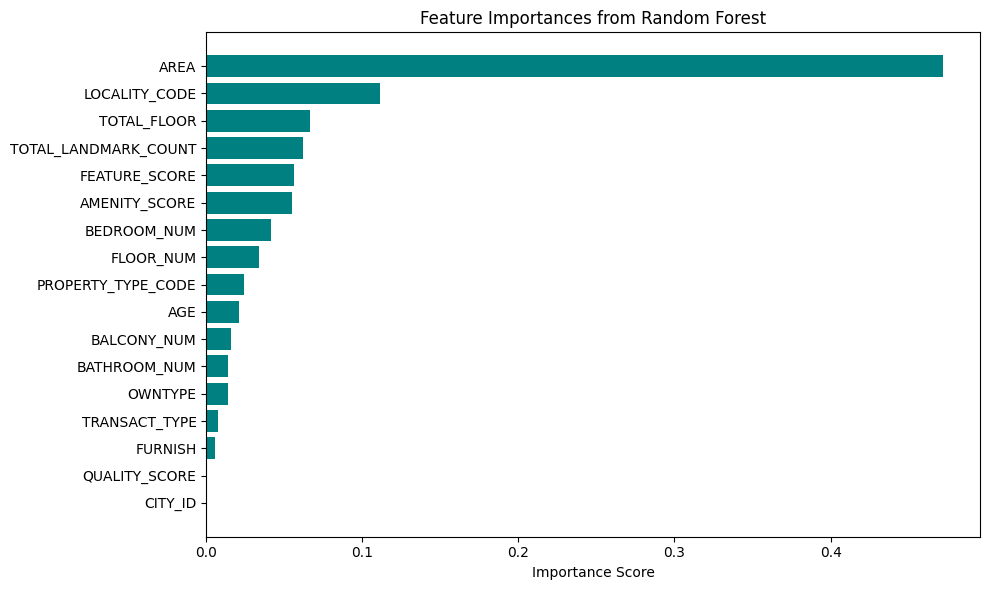

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming model is your trained RandomForestRegressor
importances = model.feature_importances_
feature_names = ml_features

# Create a DataFrame
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_df['Feature'], feature_df['Importance'])
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


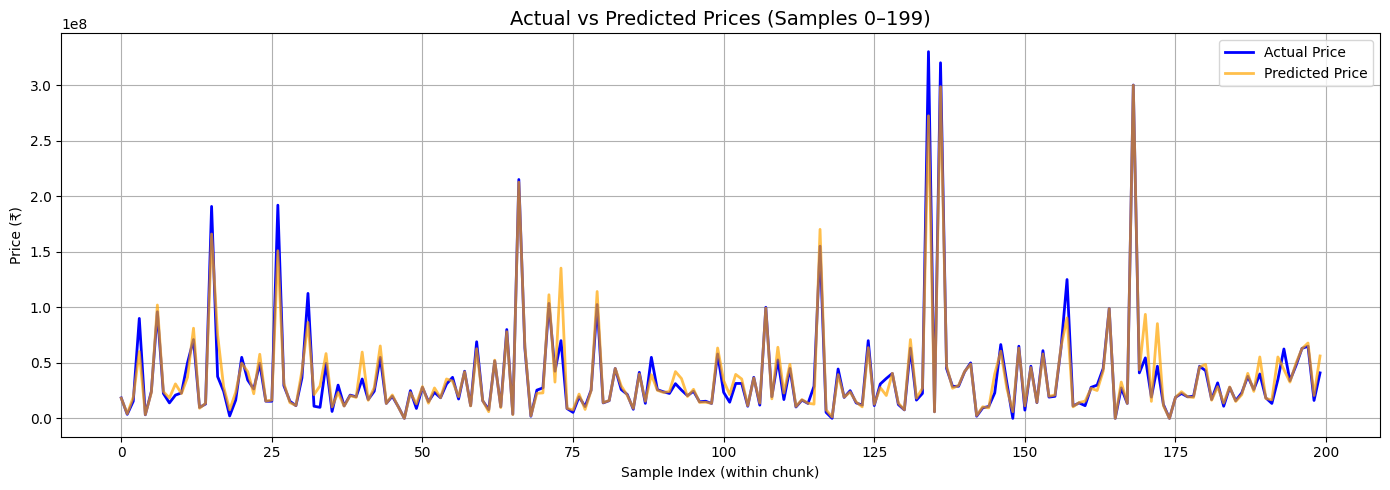

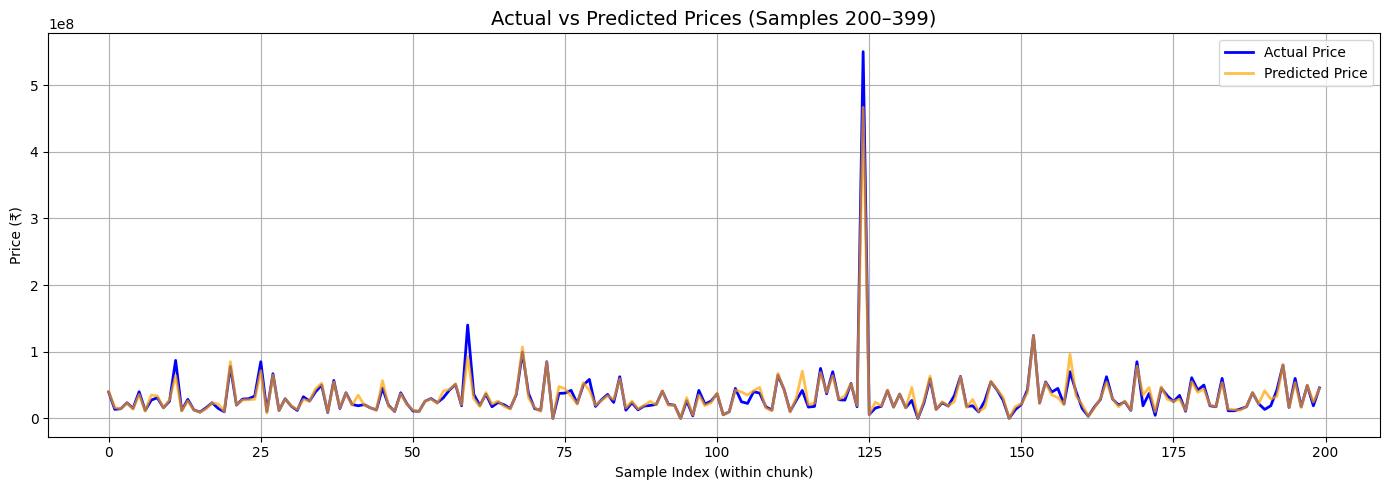

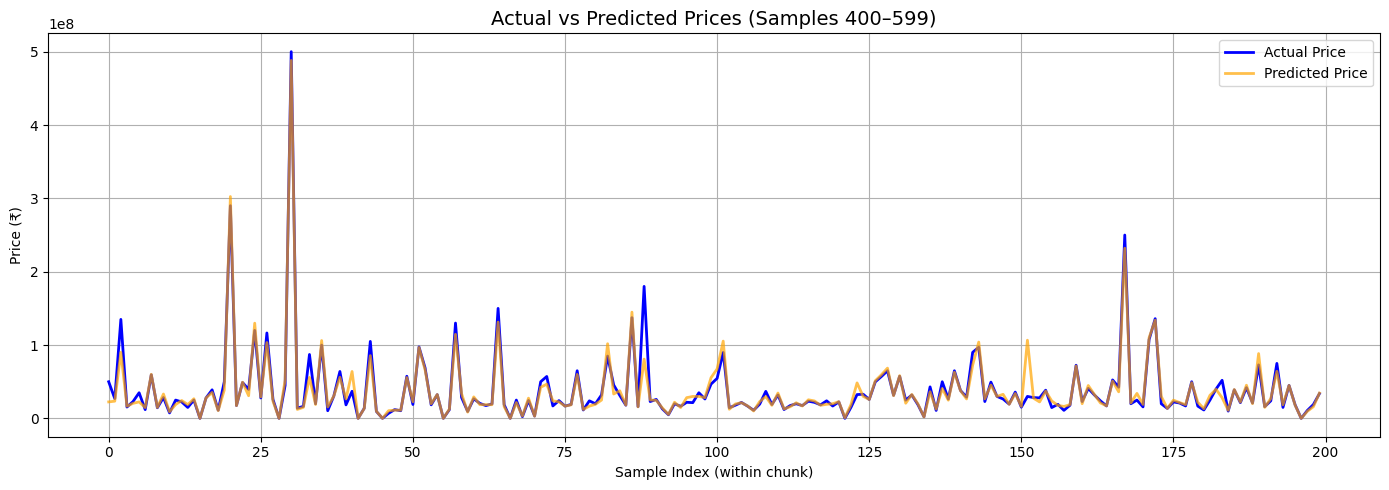

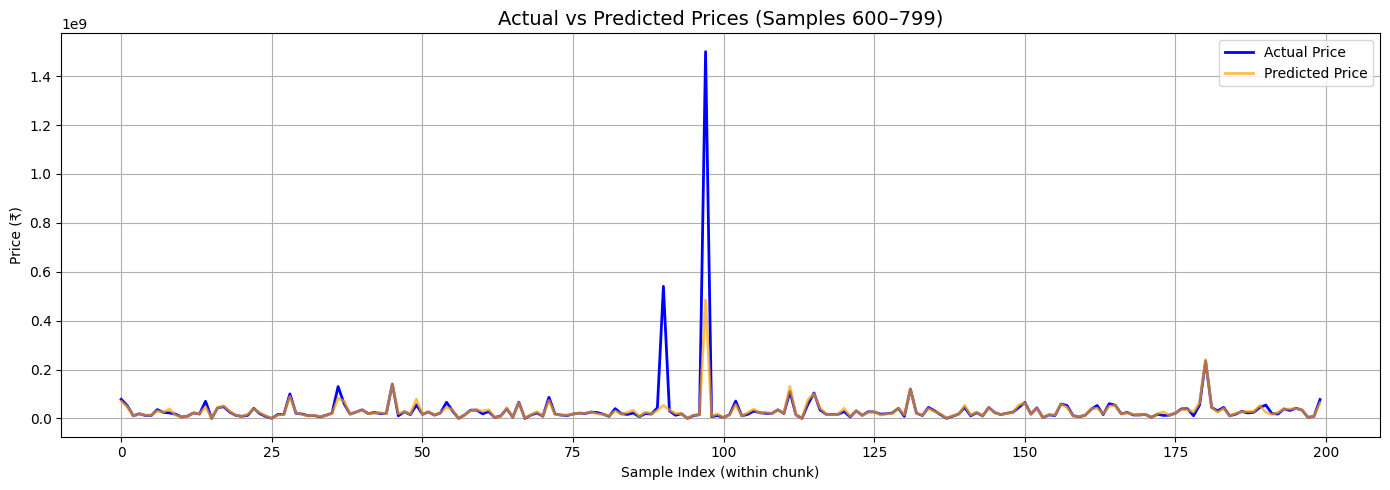

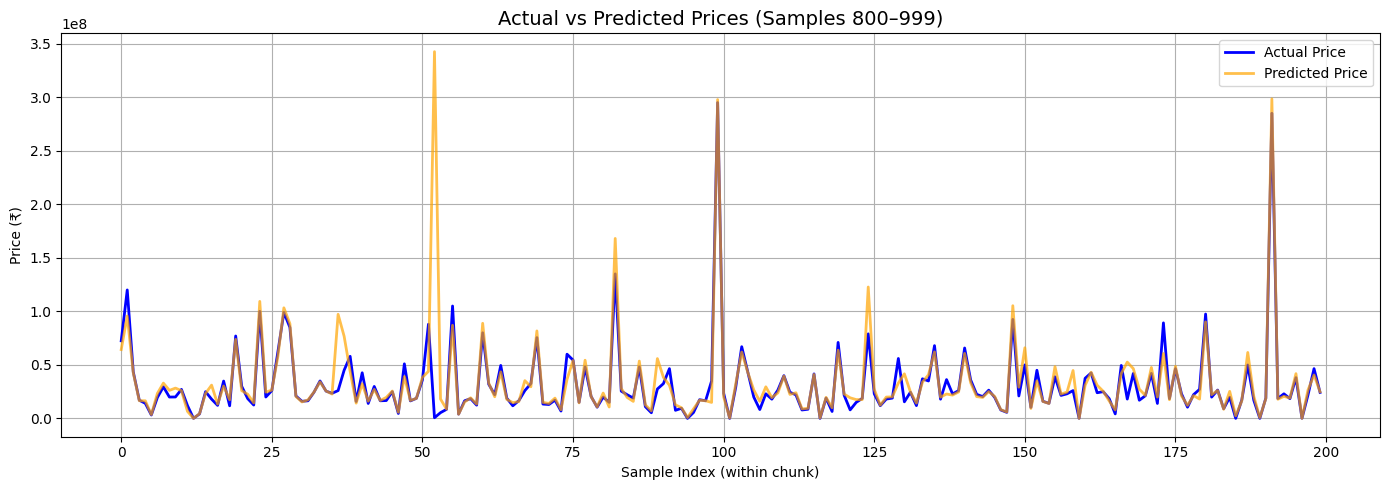

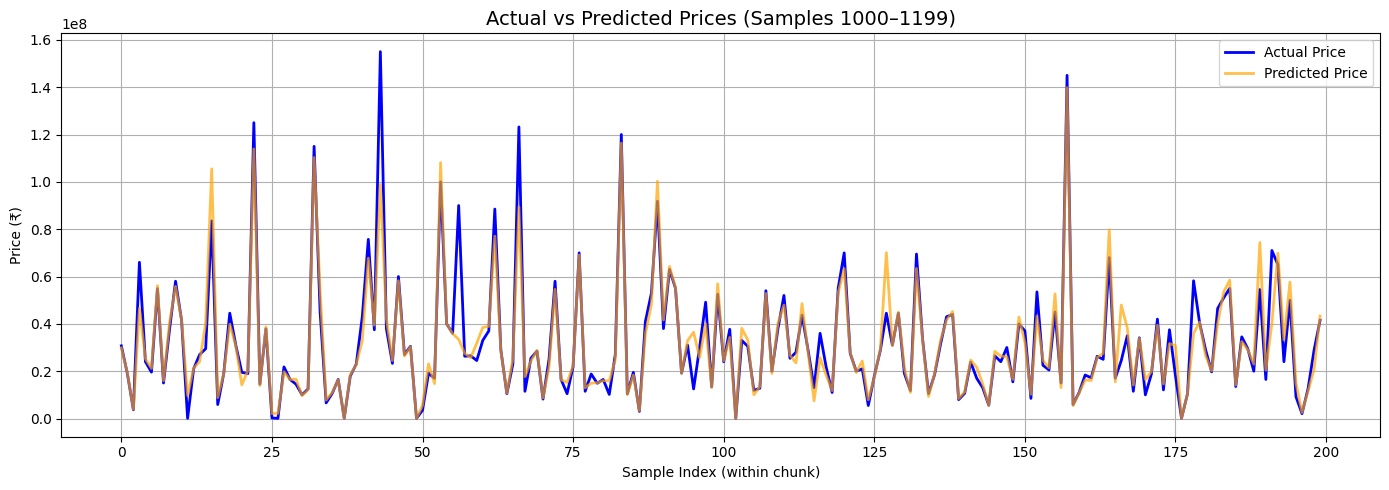

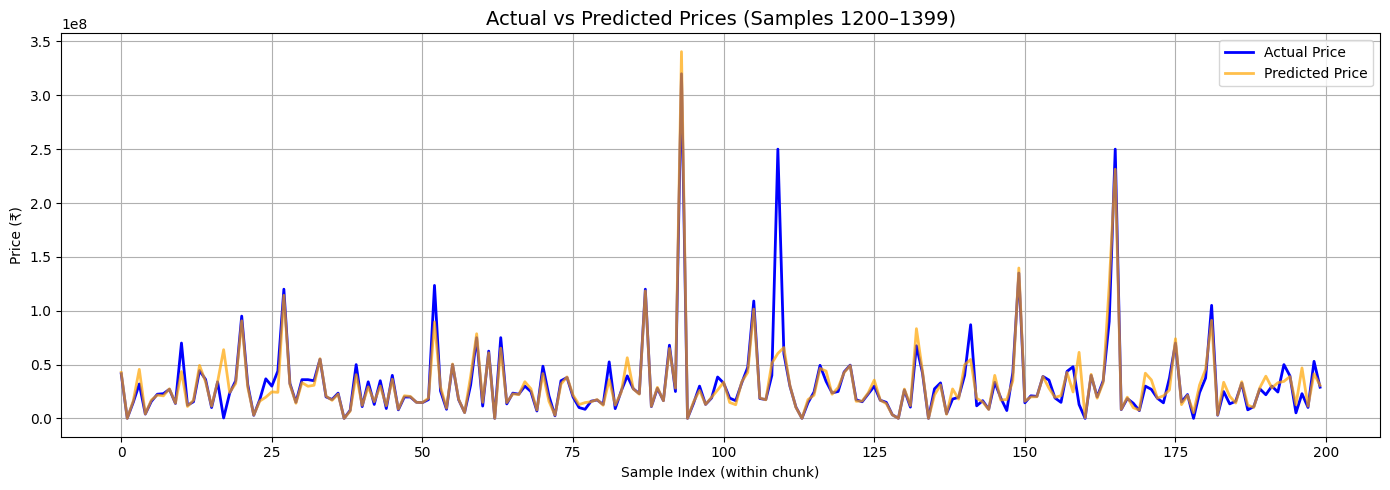

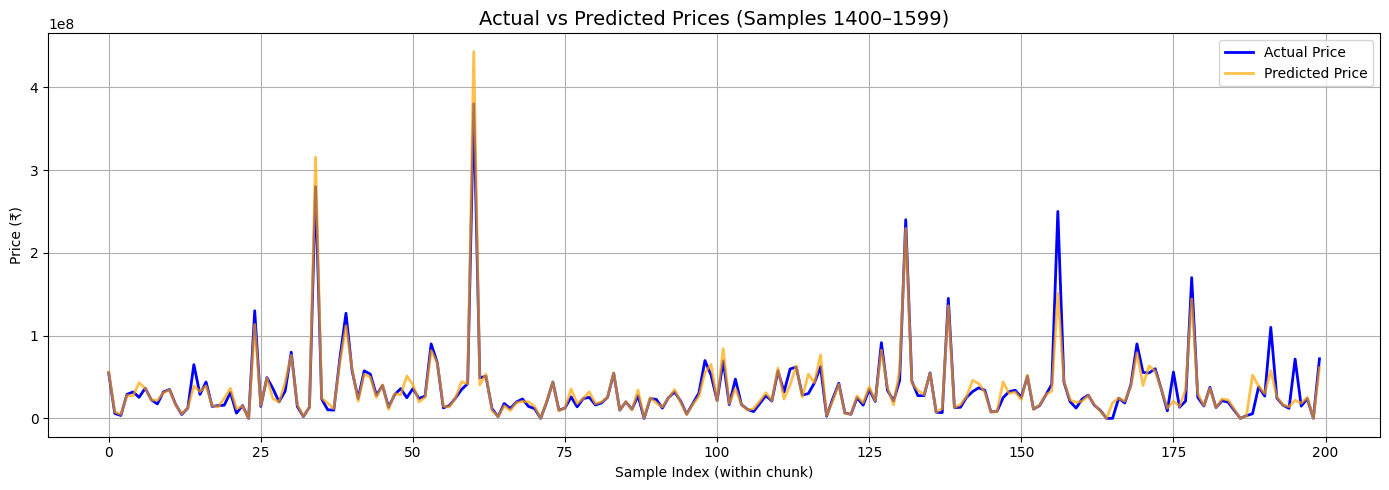

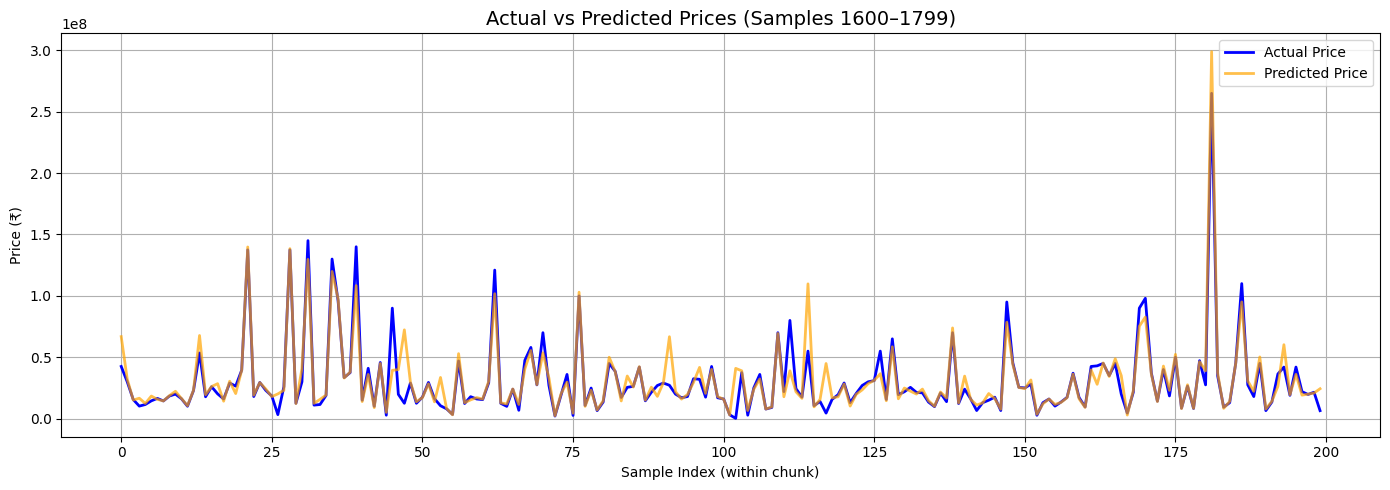

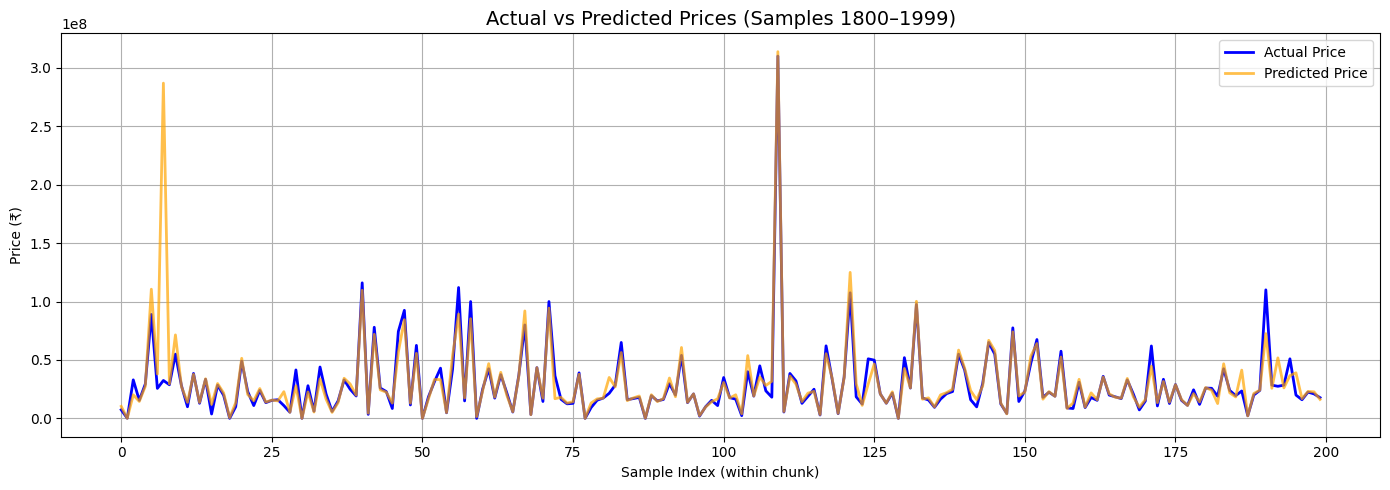

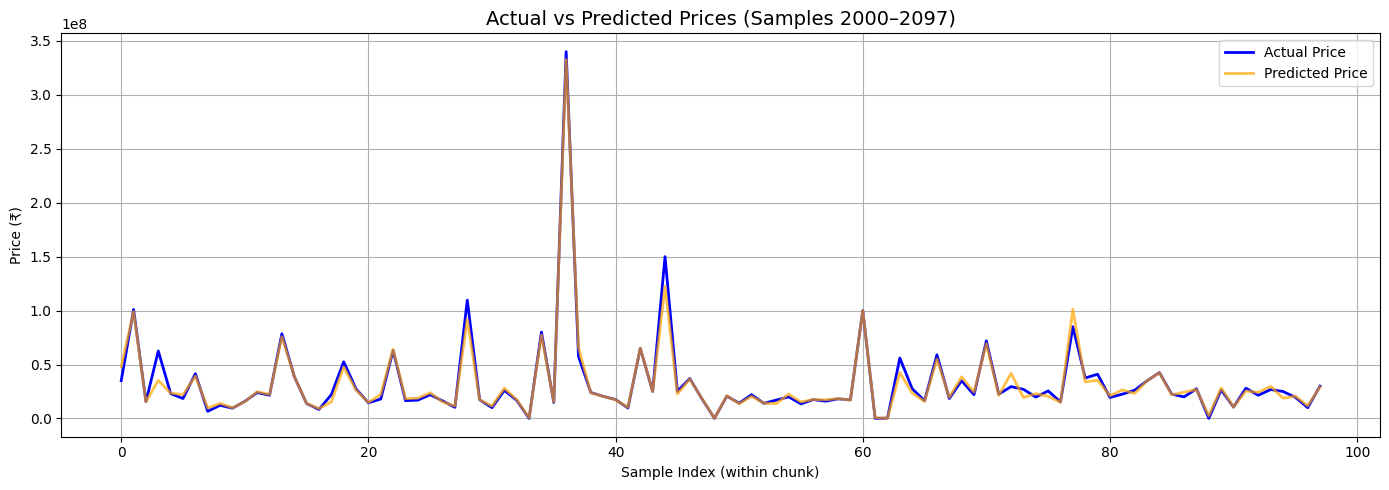

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert to aligned Series
y_actual = y_test.reset_index(drop=True)
y_predicted = pd.Series(y_pred, index=y_actual.index)

# Chunk size
chunk_size = 200
num_chunks = int(np.ceil(len(y_actual) / chunk_size))

# Plot each chunk
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(y_actual))

    plt.figure(figsize=(14, 5))
    plt.plot(y_actual[start:end].values, label='Actual Price', color='blue', linewidth=2)
    plt.plot(y_predicted[start:end].values, label='Predicted Price', color='orange', linewidth=2, alpha=0.7)
    plt.title(f'Actual vs Predicted Prices (Samples {start}–{end - 1})', fontsize=14)
    plt.xlabel('Sample Index (within chunk)')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [20]:
import numpy as np

# Ensure numpy arrays for math
y_actual = y_test.to_numpy()
y_predicted = y_pred

# 20% threshold check
tolerance = 0.20
within_tolerance = np.abs(y_predicted - y_actual) <= (tolerance * y_actual)

# Accuracy metric
tolerance_accuracy = np.mean(within_tolerance) * 100

print(f"\n✅ Prediction Accuracy (within ±20% of actual): {tolerance_accuracy:.2f}%")

# 30% threshold check
tolerance = 0.30
within_tolerance = np.abs(y_predicted - y_actual) <= (tolerance * y_actual)

# Accuracy metric
tolerance_accuracy = np.mean(within_tolerance) * 100

print(f"\n✅ Prediction Accuracy (within ±30% of actual): {tolerance_accuracy:.2f}%")



✅ Prediction Accuracy (within ±20% of actual): 76.41%

✅ Prediction Accuracy (within ±30% of actual): 85.22%


In [26]:
# --- Sample Input Dictionary ---
# Raw dictionary like a new row from CSV
raw_input = {
    'PREFERENCE': 'Buy',
    'DESCRIPTION': 'Spacious 3 BHK Apartment in a gated society',
    'PROPERTY_TYPE': 'Residential Apartment',
    'CITY': 'Gurgaon',
    'LOCALITY': 'Sector 84 Gurgaon',
    'TRANSACT_TYPE': 1,
    'OWNTYPE': 0,
    'BEDROOM_NUM': 4,
    'BATHROOM_NUM': 4,
    'BALCONY_NUM': 4,
    'PRICE_PER_UNIT_AREA': 8500,
    'FURNISH': 'Semi-Furnished',
    'FACING': 'East',
    'AGE': 2,
    'FLOOR_NUM': 14,
    'TOTAL_FLOOR': 26,
    'FEATURES': '33,23,12,46,25,47,39,1,3,6,9,40,41,30,20,42,21,32',
    'SUPERBUILTUP_SQFT': 3400,
    'AMENITIES': '20,21,32,23,46,47,39,1,6,9,40,41,30,42,33,12,25,3,102',
    'TOTAL_LANDMARK_COUNT': 4,
    'CONTACT_NAME': 'John Doe',
    'SOCIETY_NAME': 'Palm Grove',
    'CITY_ID': 1,
    'location': 'Sector 84 Gurgaon',
    'QUALITY_SCORE': 0.9,
    'MIN_PRICE': 14875000,
    'AREA': '3400 sq.ft.'
}
# --- Wrap input in DataFrame ---
input_df = pd.DataFrame([raw_input])

# --- Preprocess like original dataset ---
input_df['FURNISH'] = input_df['FURNISH'].astype('category')
input_df['FACING'] = input_df['FACING'].astype('category')
input_df['PROPERTY_TYPE'] = input_df['PROPERTY_TYPE'].astype('category')
input_df['LOCALITY'] = input_df['LOCALITY'].astype('category')
input_df['TRANSACT_TYPE'] = input_df['TRANSACT_TYPE'].fillna(0).astype(int)

# --- Clean AREA ---
input_df['AREA'] = input_df['AREA'].str.replace('sq.ft.', '', regex=False).str.strip()
input_df['AREA'] = pd.to_numeric(input_df['AREA'], errors='coerce')

# --- Encode categorical ---
input_df['PROPERTY_TYPE_CODE'] = input_df['PROPERTY_TYPE'].astype('category').cat.codes
input_df['LOCALITY_CODE'] = input_df['LOCALITY'].astype('category').cat.codes

# --- Feature & Amenity scoring ---
def score_features(feature_str):
    if pd.isna(feature_str): return 0
    ids = [int(i.strip()) for i in feature_str.split(',') if i.strip().isdigit()]
    return sum(FEATURE_SCORE_MAP.get(i, 0) for i in ids)

def score_amenities(amenity_str):
    if pd.isna(amenity_str): return 0
    ids = [int(i.strip()) for i in amenity_str.split(',') if i.strip().isdigit()]
    return sum(AMENITY_SCORE_MAP.get(i, 0) for i in ids)

input_df['FEATURE_SCORE'] = input_df['FEATURES'].apply(score_features)
input_df['AMENITY_SCORE'] = input_df['AMENITIES'].apply(score_amenities)

# --- Final feature list ---
ml_features = [
    'PROPERTY_TYPE_CODE', 'LOCALITY_CODE', 'TRANSACT_TYPE', 'OWNTYPE', 'AGE',
    'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA', 'FURNISH',
    'FLOOR_NUM', 'TOTAL_FLOOR', 'TOTAL_LANDMARK_COUNT',
    'QUALITY_SCORE', 'CITY_ID', 'FEATURE_SCORE', 'AMENITY_SCORE'
]

# Handle FURNISH if it's categorical
if input_df['FURNISH'].dtype.name == 'category':
    input_df['FURNISH'] = input_df['FURNISH'].cat.codes

# Subset for model input
model_input = input_df[ml_features].fillna(0)

# Predict
predicted_price = model.predict(model_input)[0]
print(f"💰 Predicted Property Price: ₹{predicted_price:,.2f}")



💰 Predicted Property Price: ₹35,290,050.00
